# Take a look at Scania Truck data.
[Database hosted at UCI Machine Learning Repository Site](http://archive.ics.uci.edu/ml/datasets/APS+Failure+at+Scania+Trucks#)

There are no label errors. However, nearly every row is missing some kind of measurement. Will need to impute the data one way or another, as dropping rows with any missing measurements leaves only 691 of 60k rows.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [26]:
# Original dataset has some text at the top of the csv, above the headers.
# File below has that text removed, leaving only header row and data.
aps = pd.read_csv('./aps_failure_training_set_no_headers.csv')

In [27]:
# Nearly all data enters the dataframe as a string object.
aps.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 171 entries, class to eg_000
dtypes: int64(1), object(170)
memory usage: 78.3+ MB


In [28]:
# Checking for weird labels
aps['class'].unique()

array(['neg', 'pos'], dtype=object)

In [76]:
# Number of negative examples
mask = aps['class']=='neg'
aps[mask]['class'].shape[0]

59000

In [75]:
# Number of positive examples
mask = aps['class']!='neg'
aps[mask]['class'].shape[0]

1000

In [31]:
# Create new dataframe for EDA
# For each column in dataframe, make that column numeric

X = aps.iloc[:,1:].copy(deep=True)
y = aps['class']

In [32]:
# Convert target variable to numeric

print('Pre-conversion y', y.dtype, y.value_counts(), sep = '\n')
y = pd.Series([0 if lbl == 'neg' else 1 for lbl in y], name = 'class')
print('Post-conversion y', y.dtype, y.value_counts(), sep = '\n')

Pre-conversion y
object
neg    59000
pos     1000
Name: class, dtype: int64
Post-conversion y
int64
0    59000
1     1000
Name: class, dtype: int64


In [34]:
# Convert columns to numeric.
print(X.info())
for column in X.columns:
    X[column]= pd.to_numeric(X[column], errors = 'coerce')
    
print(X.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 170 entries, aa_000 to eg_000
dtypes: int64(1), object(169)
memory usage: 77.8+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 170 entries, aa_000 to eg_000
dtypes: float64(169), int64(1)
memory usage: 77.8 MB
None


Columns above threshold: 28


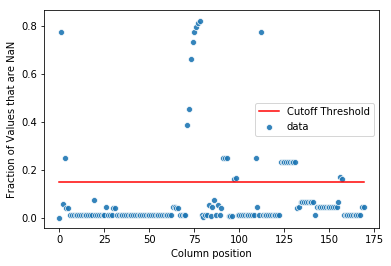

In [43]:
# How prevalent are Nan values?
def get_nan_frac_cols(df, cutoff = 0.25):
    '''
    Returns column labels for columns with a NaN values fraction >= a cutoff fraction.
    ---
    Parameters
    df: Pandas dataframe
    
    Returns
    List of columns with NaN fraction > cutoff fraction
    '''
    nan_frac_vec, cols_high_nan = [], []
    
    for column in df.columns:
        nan_frac = df[column][df[column].isnull()].size/df.shape[0]
        nan_frac_vec.append(nan_frac)

        if nan_frac >= cutoff:
            cols_high_nan.append(column)
            
    
    sns.scatterplot(range(df.shape[1]),nan_frac_vec, alpha = 0.9, label='data')
    plt.plot(range(df.shape[1]), np.ones(df.shape[1])*cutoff,'r-', label='Cutoff Threshold')
    plt.legend(loc='best')
    plt.ylabel('Fraction of Values that are NaN')
    plt.xlabel('Column position')
    
    return cols_high_nan

nan_cols = get_nan_frac_cols(X, 0.15)
print('Columns above threshold:',len(nan_cols))

## Dealing with NaN:
Current options:
* drop columns with mostly nan, then drop any row with nan. How many observations do you lose?
* experiment with sklearn.preprocessing.Imputer
* read sklearn [imputation guide](http://scikit-learn.org/stable/modules/impute.html)
* take mean values
* use kNN with features that aren't null
* determine on which features it would be reasonable to impute

In [41]:
#Dropping idea: Remove columns w/ NaN percent above a threshold, then drop all corresponding rows
X_no_nan = X.drop(nan_cols, axis=1).dropna()
X_no_nan.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54143 entries, 0 to 59999
Columns: 142 entries, aa_000 to eg_000
dtypes: float64(141), int64(1)
memory usage: 59.1 MB


[]

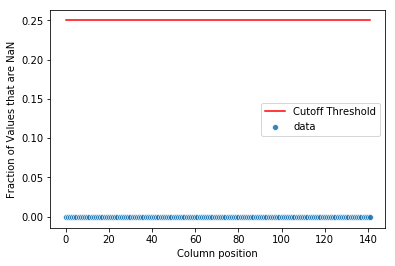

In [44]:
get_nan_frac_cols(X_no_nan)

In [63]:
# Check that we still have a good amount of negative and positive classes
y_no_nan = y[X_no_nan.index]
y_no_nan.shape

(54143,)

In [69]:
# Number of positive classes
y_no_nan[y_no_nan==1].sum()

405

In [74]:
np.sum(y_no_nan==0)

53738

Dropping high columns with a high percentage of `NaN` values, then culling the observations with any `NaN` value still leaves 54,143 observations, down from 60,000. We also retained 142 of the 170 featurs. However, of the original 1000 positive examples, only 405 remain. The negative class still has 53,738 observations.  

Percent loss, by class, when dropping NaN values:
* Positive class: 59.5%
* Negative class:  0.7%  

Takeaways:  
1) I still have enough examples to train on.  
2) Since the lack of measurements disproportionately affects one class, it could be that the number of missing values is correlated with the class type, and thus should become a feature. To incorporate this, I'd need to impute values (strategically) for the observations that were eliminated.

0.007480191345141551

array([       nan, 0.9830187 , 0.79208391, 0.51863014])

## Adding database to SQL
Because I don't think it's efficient to write out the 170 columns with their respective types, so I'm going to try to manipulate the columns list into an SQL table creation command.

In [81]:
test = tuple(column + ' col_type' for column in X.columns[:2])
print(test)

('aa_000 col_type', 'ab_000 col_type')


In [83]:
', '.join(thing for thing in test)

'aa_000 col_type, ab_000 col_type'